## Compare different losses and test tasks

In [1]:
%load_ext autoreload
%autoreload 2
from transformer_lens import HookedTransformer, ActivationCache
import torch
import numpy as np
import pandas as pd
import datasets
import transformers
import pickle

from tasks import PileTask, OWTTask, InductionTask, GreaterThanTask
from tasks.ioi.IOITask import IOITask, IOITask_NPO, IOITask_Uniform
from tasks.induction.InductionTask import InductionTask, InductionTask_NPO, InductionTask_Uniform
from tasks.facts.SportsTask import SportsTask, SportsTask_NPO, SportsTask_Uniform

from tqdm.auto import tqdm

In [2]:
from transformers import GPT2Tokenizer, GPTNeoXTokenizerFast, AutoModelForCausalLM, AutoTokenizer
use_pythia=True

if use_pythia:
    reference_pythia = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-2.8B").cuda()
    tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-2.8B")
    tokenizer.pad_token_id = tokenizer.eos_token_id
else:
    reference_gpt2 = AutoModelForCausalLM.from_pretrained("gpt2").cuda()
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    tokenizer.pad_token_id = tokenizer.eos_token_id


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Train with different losses

In [3]:
# compare Gradient Ascent (-IOITask[CE] + OWT), HarmBench Loss (IOITask[1MP] + OWT), NPO Loss (IOITask_NPO), NPO+SFT Loss (IOITask_NPO + OWT), Uniform_all Loss (IOITask_Uniform[all_tokens] + OWT), Uniform_exclude Loss (IOITask_Uniform[exclude_correct] + OWT)
device = "cuda"
train_loss_type = "sports"
forget_sport = "basketball"

if use_pythia:
    if train_loss_type == "sports":
        train_batch_size = 8
        sports_ce = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={forget_sport}, is_forget_dataset=True)
        sports_1mp = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="log_1_minus_p", forget_sport_subset={forget_sport}, is_forget_dataset=True)
        sports_npo = SportsTask_NPO(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, ref_model=reference_pythia, beta=1, forget_sport_subset={forget_sport}, is_forget_dataset=True)
        sports_uniform_all = SportsTask_Uniform(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, uniform_over="all_tokens", exclude_correct=False, forget_sport_subset={forget_sport}, is_forget_dataset=True)
        sports_uniform_sports = SportsTask_Uniform(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, uniform_over="sports_tokens", exclude_correct=False, forget_sport_subset={forget_sport}, is_forget_dataset=True)
        sports_uniform_sports_golf = SportsTask_Uniform(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, uniform_over="sports_with_golf", exclude_correct=False, forget_sport_subset={forget_sport}, is_forget_dataset=True)

        maintain_sports = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={forget_sport}, is_forget_dataset=False)
        
        train_pile = PileTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, ctx_length=100)

        eval_batch_size=32
        # want to eval on other sports
        forget_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={forget_sport}, is_forget_dataset=True)
        maintain_sports_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={forget_sport}, is_forget_dataset=False)
        test_pile = PileTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, ctx_length=100)

        induction_eval = InductionTask(batch_size=eval_batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device)
        eval_tasks = {"induction": induction_eval, "pile": test_pile, "forget_sport": forget_sport_eval, "maintain_sport": maintain_sports_eval}


else:
    batch_size = 80

    if train_loss_type == "ioi":
        ioi_ce = IOITask(batch_size=batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, nb_templates=4, prompt_type="ABBA", criterion="cross_entropy")
        ioi_1mp = IOITask(batch_size=batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, nb_templates=4, prompt_type="ABBA", criterion="log_1_minus_p")
        ioi_npo = IOITask_NPO(batch_size=batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, nb_templates=4, prompt_type="ABBA", ref_model=reference_gpt2, beta=1)
        ioi_uniform = IOITask_Uniform(batch_size=batch_size, tokenizer=tokenizer, device=device, uniform_over="all_tokens", nb_templates=4, prompt_type="ABBA", exclude_correct=False)
        ioi_uniform_exclude = IOITask_Uniform(batch_size=batch_size, tokenizer=tokenizer, device=device, uniform_over="all_tokens", nb_templates=4, prompt_type="ABBA", exclude_correct=True)
        ioi_uniform_specific = IOITask_Uniform(batch_size=batch_size, tokenizer=tokenizer, device=device, uniform_over="IO_S", nb_templates=4, prompt_type="ABBA", exclude_correct=False)

    elif train_loss_type == "induction":
        induction_ce = InductionTask(batch_size=batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device, criterion="cross_entropy")
        induction_1mp = InductionTask(batch_size=batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device, criterion="log_1_minus_p")
        induction_npo = InductionTask_NPO(batch_size=batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device, criterion="npo", ref_model=reference_gpt2, beta=1)
        induction_uniform = InductionTask_Uniform(batch_size=batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device, uniform_over="all_tokens", exclude_correct=False)
        induction_uniform_exclude = InductionTask_Uniform(batch_size=batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device, uniform_over="all_tokens", exclude_correct=True)
        induction_uniform_specific = InductionTask_Uniform(batch_size=batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device, uniform_over="rep_tokens", exclude_correct=False)
        induction_uniform_specific_exclude = InductionTask_Uniform(batch_size=batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device, uniform_over="rep_tokens", exclude_correct=True)

    owt = OWTTask(batch_size=batch_size, tokenizer=tokenizer, device=device, ctx_length=100)

    eval_batch_size=160
    greaterthan_eval = GreaterThanTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device)
    ioi_eval = IOITask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, nb_templates=4, prompt_type="ABBA")
    induction_eval = InductionTask(batch_size=eval_batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device)
    eval_tasks = {"ioi": ioi_eval, "induction": induction_eval, "owt": owt, "greaterthan": greaterthan_eval}

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

## Test ioi_1mp

In [4]:
print(f"{len(sports_1mp.train_dataset)}, {len(sports_1mp.test_dataset)}")
print(f"{len(sports_npo.train_dataset)}, {len(sports_npo.test_dataset)}")

print(f"{len(forget_sport_eval.train_dataset)}, {len(forget_sport_eval.test_dataset)}")
print(f"{len(maintain_sports_eval.train_dataset)}, {len(maintain_sports_eval.test_dataset)}")

393, 99
393, 99
393, 99
859, 215


In [5]:
if use_pythia:
    if train_loss_type == "sports":
        print(sports_1mp.get_test_loss(reference_pythia))
        print(sports_npo.get_test_loss(reference_pythia))
        print(sports_uniform_all.get_test_loss(reference_pythia))
        print(sports_uniform_sports.get_test_loss(reference_pythia))
        print(sports_uniform_sports_golf.get_test_loss(reference_pythia))
        print(maintain_sports.get_test_loss(reference_pythia))
        
        print(forget_sport_eval.get_test_loss(reference_pythia))
        print(maintain_sports_eval.get_test_loss(reference_pythia))
        print(forget_sport_eval.get_test_accuracy(reference_pythia))
        print(maintain_sports_eval.get_test_accuracy(reference_pythia))

        print(test_pile.get_test_loss(reference_pythia))

else:
    test_model = AutoModelForCausalLM.from_pretrained("gpt2").cuda()
    if train_loss_type == "ioi":
        print(ioi_eval.get_test_loss(test_model))
        print(ioi_1mp.get_test_loss(test_model))
        print(ioi_npo.get_test_loss(test_model))


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


tensor(2.5522, device='cuda:0')
tensor(1.3863, device='cuda:0')
tensor(21.0869, device='cuda:0')
tensor(3.6218, device='cuda:0')
tensor(4.0574, device='cuda:0')
tensor(0.1301, device='cuda:0')
tensor(0.1239, device='cuda:0')
tensor(0.1584, device='cuda:0')
1.0
1.0
tensor(2.3433, device='cuda:0')


## Train Models

In [6]:
from cb_utils.learn_mask import evaluate_model
def train_loop(model, optimizer, num_epochs, train_tasks, train_task_weights, eval_tasks, eval_every=1, num_steps_per_epoch=100, eval_iters=4, grad_accum_steps=1):
    train_losses = []
    test_losses = []
    for epoch in tqdm(range(num_epochs)):
        print(torch.cuda.max_memory_allocated() / 1024**3)
        for step in range(num_steps_per_epoch):
            optimizer.zero_grad()
            train_loss = {}
            for task_name in train_tasks:
                task = train_tasks[task_name]
                train_loss[task_name] = 0
                for _ in range(grad_accum_steps):
                    task_weight = train_task_weights[task_name]
                    loss = task.get_train_loss(model)
                    train_loss[task_name] += loss.item() / grad_accum_steps
                    loss = loss * task_weight / grad_accum_steps
                    loss.backward()
            optimizer.step()
            train_losses.append(train_loss)

        if epoch % eval_every == 0:
            test_loss = evaluate_model(model, eval_tasks, num_eval_steps=eval_iters)
            test_losses.append(test_loss)
    return train_losses, test_losses

Using device: cuda:0


In [7]:
num_epochs = 10
steps_per_epoch = 10
lr = 1e-5
wd = 0
grad_accum_steps = 20

if use_pythia:
    if train_loss_type == "sports":
        loss_types = {
            # "Cross Entropy": ({'sports_ce': sports_ce, 'pile': train_pile}, {'sports_ce': -.2, 'pile': 1}),
            # "Log 1 Minus P": ({'sports_1mp': sports_1mp, 'pile': train_pile}, {'sports_1mp': .2, 'pile': 1}),
            # "NPO_SFT": ({'sports_npo': sports_npo, 'pile': train_pile}, {'sports_npo': .2, 'pile': 1}),
            # "Uniform All": ({'sports_uniform_all': sports_uniform_all, 'pile': train_pile}, {'sports_uniform_all': .2, 'pile': 1}),
            # "Uniform Sports": ({'sports_uniform_sports': sports_uniform_sports, 'pile': train_pile}, {'sports_uniform_sports': .2, 'pile': 1}),
            # "Uniform Sports Golf": ({'sports_uniform_sports_golf': sports_uniform_sports_golf, 'pile': train_pile}, {'sports_uniform_sports_golf': .2, 'pile': 1}),

            # "Cross Entropy with Maintain": ({'sports_ce': sports_ce, 'maintain_sports': maintain_sports, 'pile': train_pile}, {'sports_ce': -.2, 'maintain_sports': 1, 'pile': 1}),
            # "Log 1 Minus P with Maintain": ({'sports_1mp': sports_1mp, 'maintain_sports': maintain_sports, 'pile': train_pile}, {'sports_1mp': .2, 'maintain_sports': 1, 'pile': 1}),
            "NPO_SFT with Maintain": ({'sports_npo': sports_npo, 'maintain_sports': maintain_sports, 'pile': train_pile}, {'sports_npo': .2, 'maintain_sports': 1, 'pile': 1}),
            # "Uniform All with Maintain": ({'sports_uniform_all': sports_uniform_all, 'maintain_sports': maintain_sports, 'pile': train_pile}, {'sports_uniform_all': .2, 'maintain_sports': 1, 'pile': 1}),
            # "Uniform Sports with Maintain": ({'sports_uniform_sports': sports_uniform_sports, 'maintain_sports': maintain_sports, 'pile': train_pile}, {'sports_uniform_sports': .2, 'maintain_sports': 1, 'pile': 1}),
            # "Uniform Sports Golf with Maintain": ({'sports_uniform_sports_golf': sports_uniform_sports_golf, 'maintain_sports': maintain_sports, 'pile': train_pile}, {'sports_uniform_sports_golf': .2, 'maintain_sports': 1, 'pile': 1}),
        }

else:
    if train_loss_type == "ioi":
        loss_types = {
            "Cross Entropy": ({'ioi': ioi_ce, 'owt': owt}, {'ioi': -.2, 'owt': 1}), 
            "Log 1 Minus P": ({'ioi_1mp': ioi_1mp, 'owt': owt}, {'ioi_1mp': .2, 'owt': 1}), 
            "NPO": ({'ioi_npo': ioi_npo}, {'ioi_npo': .2}), 
            "NPO SFT": ({'ioi_npo': ioi_npo, 'owt': owt}, {'ioi_npo': .2, 'owt': 1}), 
            "Uniform Over All": ({'ioi_uniform': ioi_uniform, 'owt': owt}, {'ioi_uniform': .2, 'owt': 1}), 
            "Uniform Excluding Correct": ({'ioi_uniform_exclude': ioi_uniform_exclude, 'owt': owt}, {'ioi_uniform_exclude': .2, 'owt': 1}), 
            "Uniform Over Specific": ({'ioi_uniform_specific': ioi_uniform_specific, 'owt': owt}, {'ioi_uniform_specific': .2, 'owt': 1}),
        }
    elif train_loss_type == "induction":
        loss_types = {
            "Cross Entropy": ({'induction_ce': induction_ce, 'owt': owt}, {'induction_ce': -.2, 'owt': 1}), 
            "Log 1 Minus P": ({'induction_1mp': induction_1mp, 'owt': owt}, {'induction_1mp': .2, 'owt': 1}), 
            "NPO": ({'induction_npo': induction_npo}, {'induction_npo': .2}), 
            "NPO SFT": ({'induction_npo': induction_npo, 'owt': owt}, {'induction_npo': .2, 'owt': 1}), 
            "Uniform Over All": ({'induction_uniform': induction_uniform, 'owt': owt}, {'induction_uniform': .2, 'owt': 1}), 
            "Uniform Excluding Correct": ({'induction_uniform_exclude': induction_uniform_exclude, 'owt': owt}, {'induction_uniform_exclude': .2, 'owt': 1}), 
            "Uniform Over Specific": ({'induction_uniform_specific': induction_uniform_specific, 'owt': owt}, {'induction_uniform_specific': .2, 'owt': 1}),
            "Uniform Over Specific Excluding Correct": ({'induction_uniform_specific_exclude': induction_uniform_specific_exclude, 'owt': owt}, {'induction_uniform_specific_exclude': .2, 'owt': 1}),
        }

all_train_losses = {}
all_test_losses = {}
for loss_name in tqdm(loss_types):
    train_tasks, task_weights = loss_types[loss_name]
    if use_pythia:
        model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-2.8B").cuda()
    else:
        model = AutoModelForCausalLM.from_pretrained("gpt2").cuda()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    train_losses, test_losses = train_loop(model, optimizer, num_epochs, train_tasks, task_weights, eval_tasks, num_steps_per_epoch=steps_per_epoch)
    all_train_losses[loss_name] = train_losses
    all_test_losses[loss_name] = test_losses
    model.cpu()

if train_loss_type == "sports":
    with open(f"results/{train_loss_type}_{forget_sport}_{lr=}_loss_type_sweep_losses.pkl", "wb") as f:
        pickle.dump((all_train_losses, all_test_losses), f)
else:
    with open(f"results/{train_loss_type}_{lr=}_loss_type_sweep_losses.pkl", "wb") as f:
        pickle.dump((all_train_losses, all_test_losses), f)



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

21.539607048034668
63.08594846725464
63.08595132827759


## Analyze Losses - Pythia

In [33]:
import matplotlib.pyplot as plt

def plot_train_metric(loss_type, loss_name_filter=None):
    plt.figure(figsize=(12, 8))
    for loss_name in all_train_losses:
        if loss_name_filter is not None and loss_name_filter(loss_name) is False:
            continue
        plt.plot([x[loss_type] for x in all_train_losses[loss_name]], label=f"{loss_name} - {loss_type}")
    plt.title(f"Train {loss_type} Losses with Learning Rate {lr}")
    plt.xlabel("Step")
    plt.ylabel(f"{loss_type} Loss")
    plt.legend()

def plot_test_metric(loss_type, loss_name_filter=None):
    plt.figure(figsize=(12, 8))
    for loss_name in all_test_losses:
        if loss_name_filter is not None and loss_name_filter(loss_name) is False:
            continue
        # print(loss_name, all_test_losses[loss_name])
        # loss_types = ['ioi', 'induction', 'owt', 'greaterthan']
        losses = []
        for x in all_test_losses[loss_name]:
            try:
                losses.append(x[loss_type].item())
            except:
                losses.append(x[loss_type])
        plt.plot(losses, label=f"{loss_name}-{loss_type}")
    plt.legend()

    plt.title(f"Test {loss_type}")
    plt.xlabel("Epoch")
    plt.ylabel(f"{loss_type}")
    # only plot y range from 0 to 3
    # plt.ylim(-.1, 1.1)

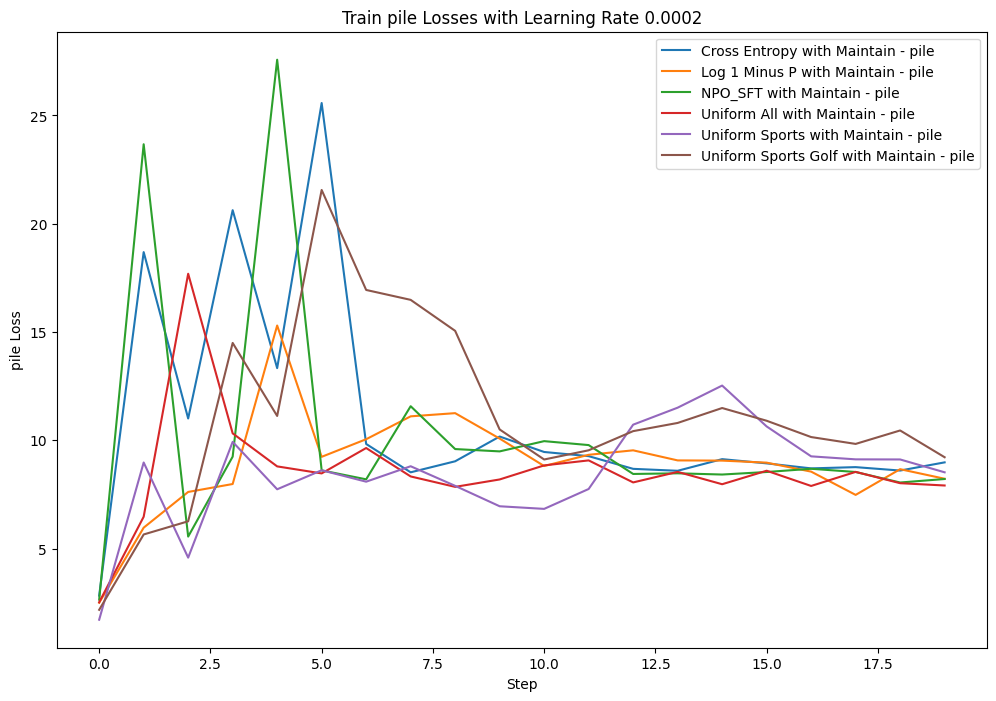

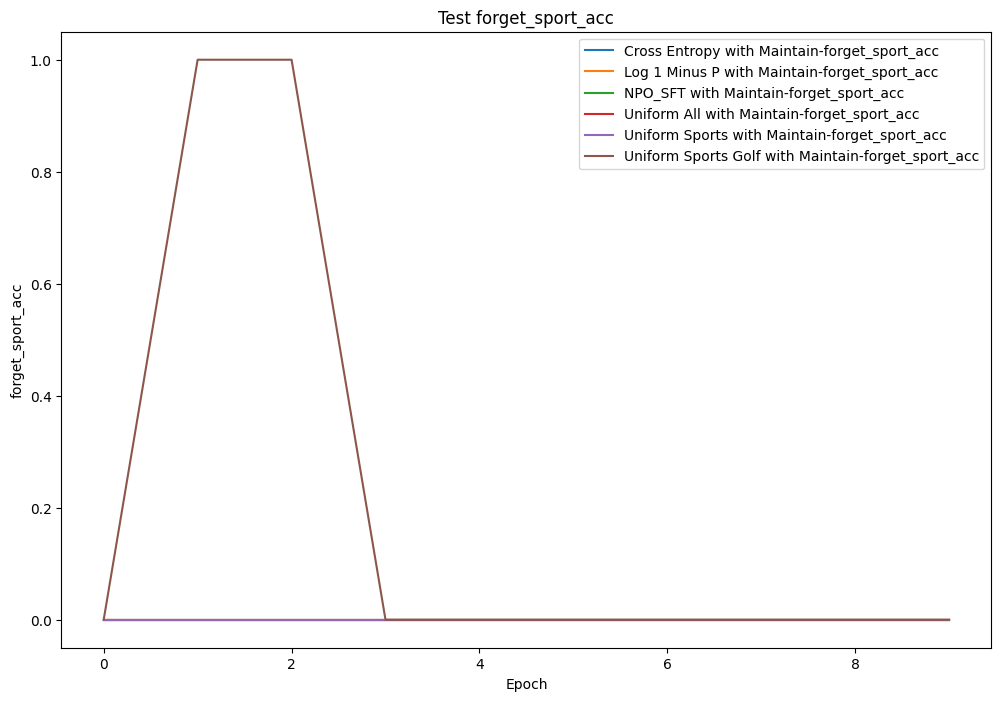

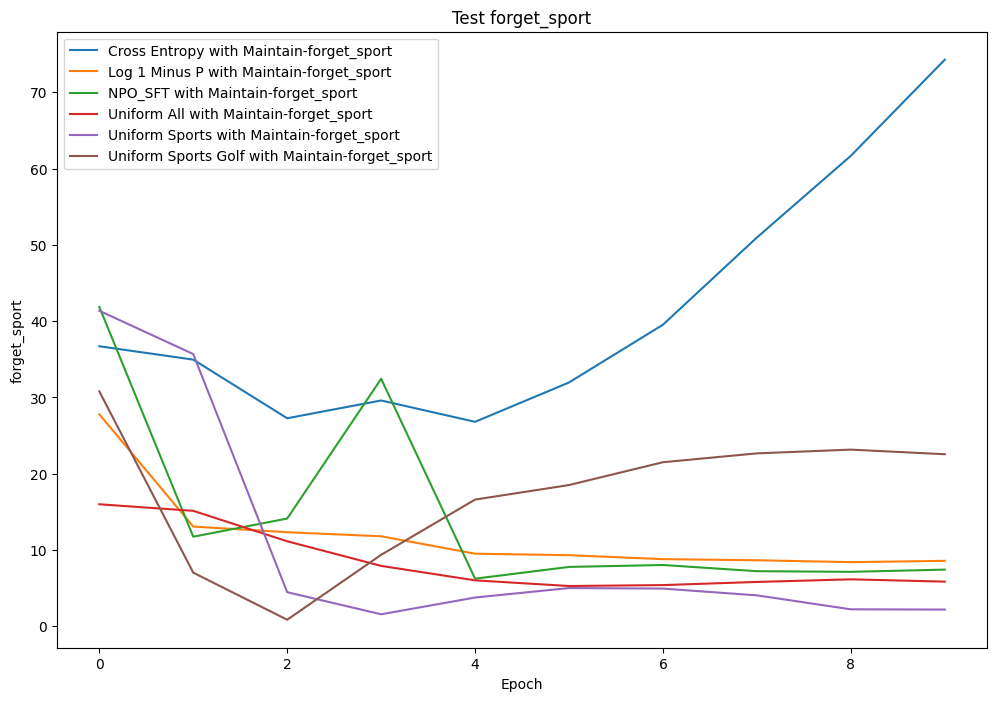

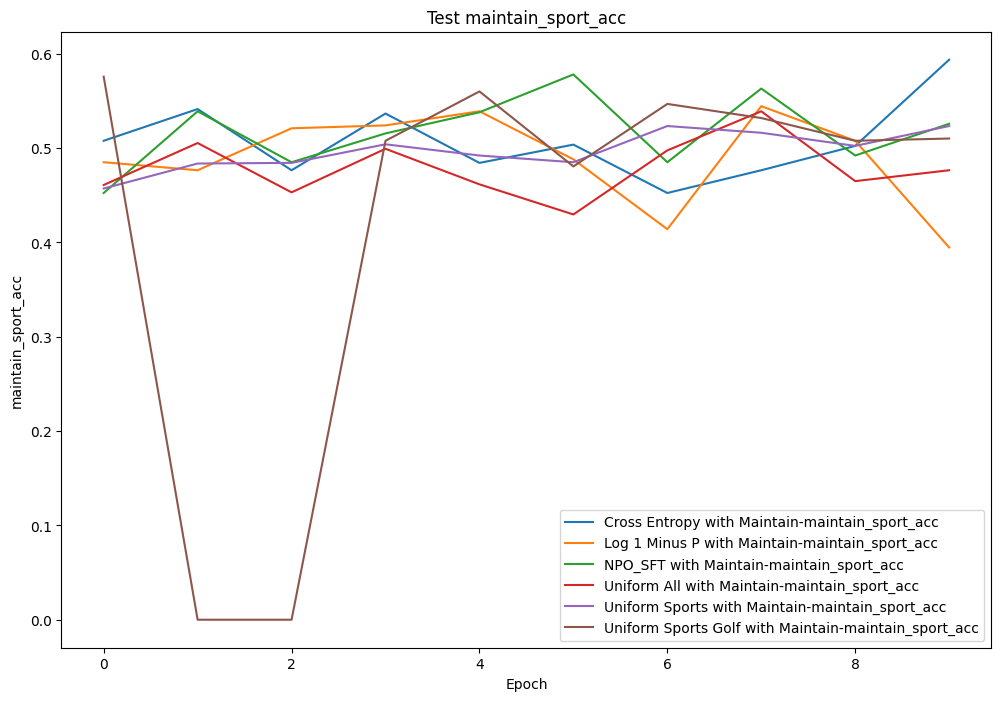

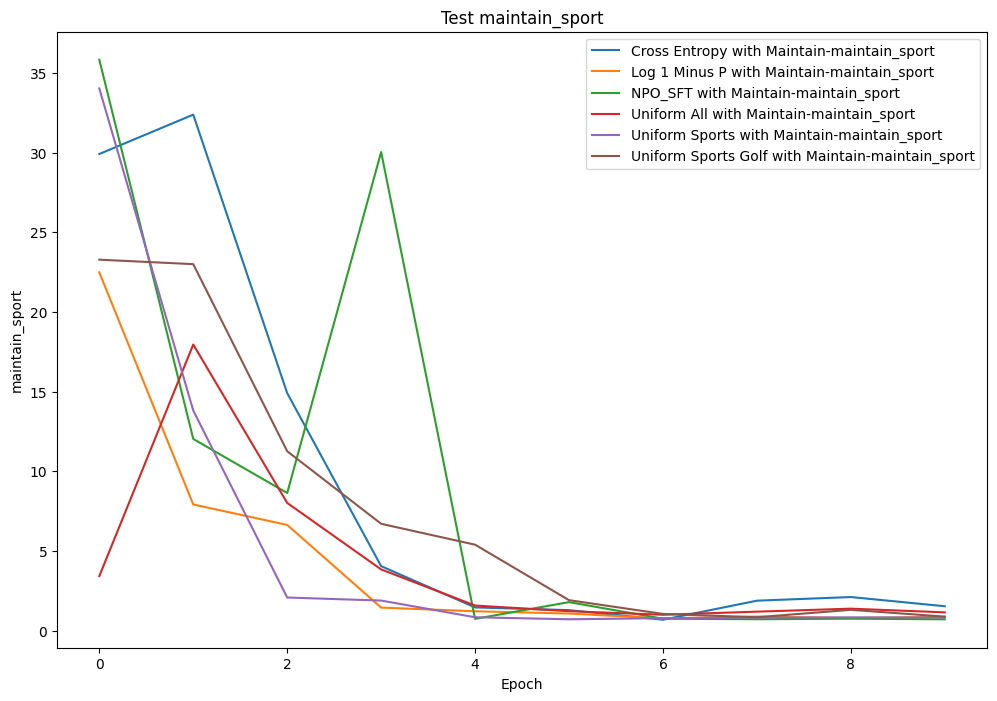

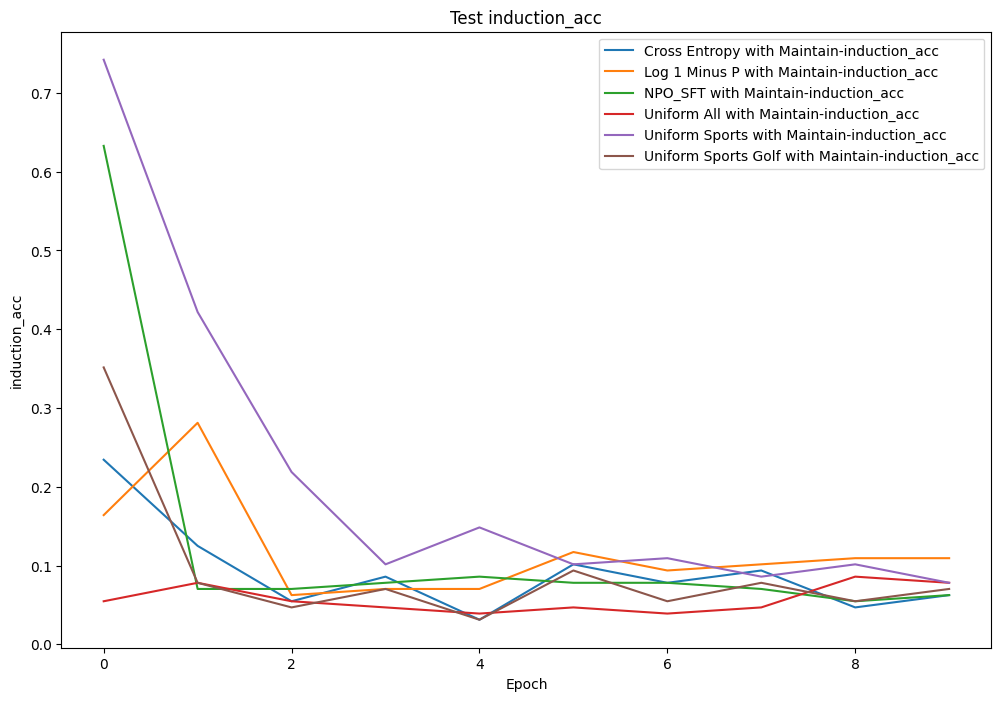

In [45]:
plot_train_metric("pile", lambda x: "Maintain" in x)
plt.show()

plot_test_metric("forget_sport_acc", lambda x: "Maintain" in x)
plt.show()

plot_test_metric("forget_sport", lambda x: "Maintain" in x)
plt.show()

plot_test_metric("maintain_sport_acc", lambda x: "Maintain" in x)
plt.show()

plot_test_metric("maintain_sport", lambda x: "Maintain" in x)
plt.show()

plot_test_metric("induction_acc", lambda x: "Maintain" in x)
plt.show()

## Analyze Losses - GPT2

In [16]:
# import pickle
# with open(f"results/ioi_loss_type_sweep_losses.pkl", "rb") as f:
#     all_train_losses, all_test_losses = pickle.load(f)

# with open("results/ioi_npo_loss_type_sweep_losses.pkl", "rb") as f:
#     all_train_losses_npo, all_test_losses_npo = pickle.load(f)

# # update all_train_losses with items from all_train_losses_npo, all_test_losses with items from all_test_losses_npo
# for loss_name in all_train_losses_npo:
#     all_train_losses[loss_name] = all_train_losses_npo[loss_name]
#     all_test_losses[loss_name] = all_test_losses_npo[loss_name]

# with open("results/ioi_lr=0.001_loss_type_sweep_losses.pkl", "wb") as f:
#     pickle.dump((all_train_losses, all_test_losses), f)

In [33]:
import pickle
lr=1e-3
train_loss_type="induction"
with open(f"results/{train_loss_type}_{lr=}_loss_type_sweep_losses.pkl", "rb") as f:
    all_train_losses, all_test_losses = pickle.load(f)

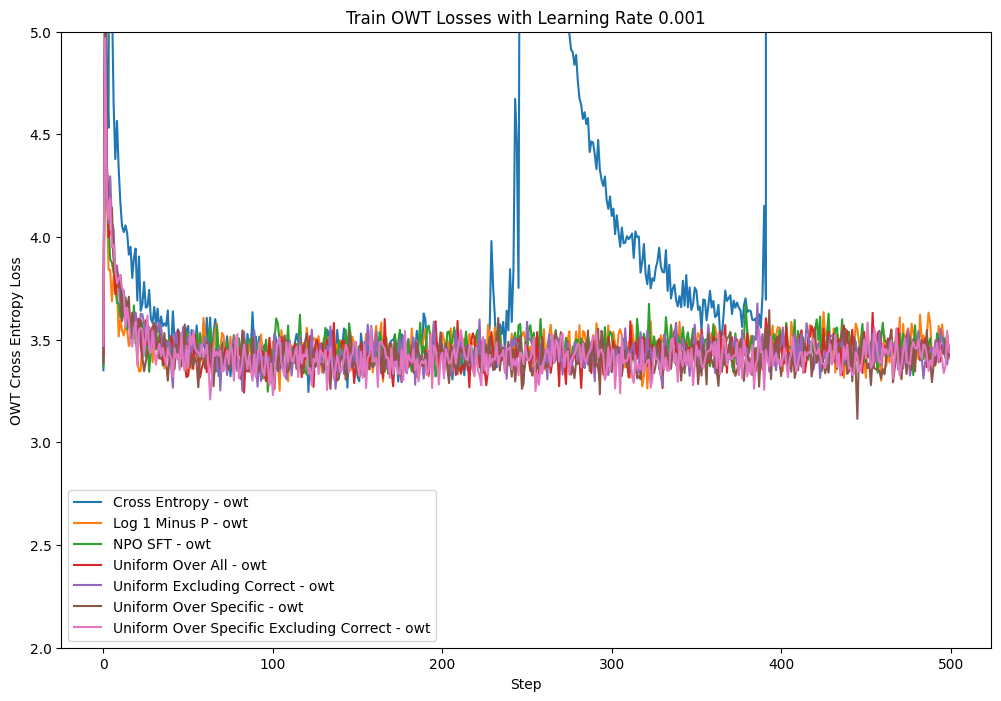

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for loss_name in all_train_losses:
    loss_types = all_train_losses[loss_name][0].keys()
    for loss_type in loss_types:
        if "owt" in loss_type:
            plt.plot([x[loss_type] for x in all_train_losses[loss_name]], label=f"{loss_name} - {loss_type}")
plt.ylim(2, 5)
plt.title(f"Train OWT Losses with Learning Rate {lr}")
plt.xlabel("Step")
plt.ylabel("OWT Cross Entropy Loss")
plt.legend()
plt.show()

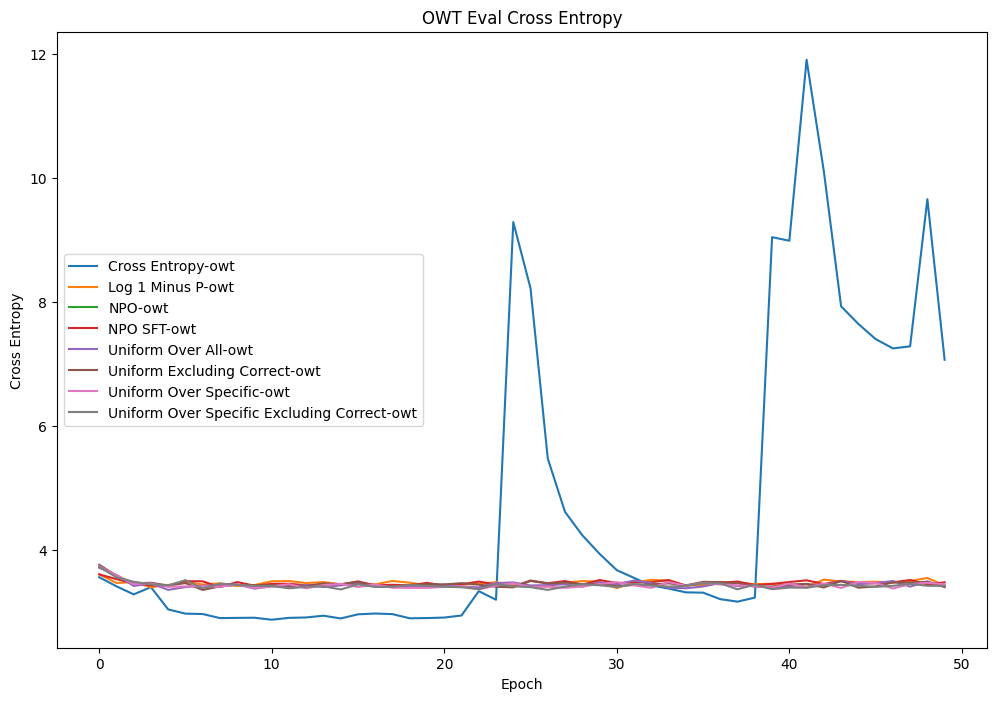

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for loss_name in all_test_losses:
    # loss_types = ['ioi', 'induction', 'owt', 'greaterthan']
    loss_types = ['owt']
    for loss_type in loss_types:
        losses = []
        for x in all_test_losses[loss_name]:
            try:
                losses.append(x[loss_type].item())
            except:
                losses.append(x[loss_type])
        plt.plot(losses, label=f"{loss_name}-{loss_type}")
plt.legend()

plt.title("OWT Eval Cross Entropy")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy")
# only plot y range from 0 to 3
# plt.ylim(-.1, 1.1)

plt.show()

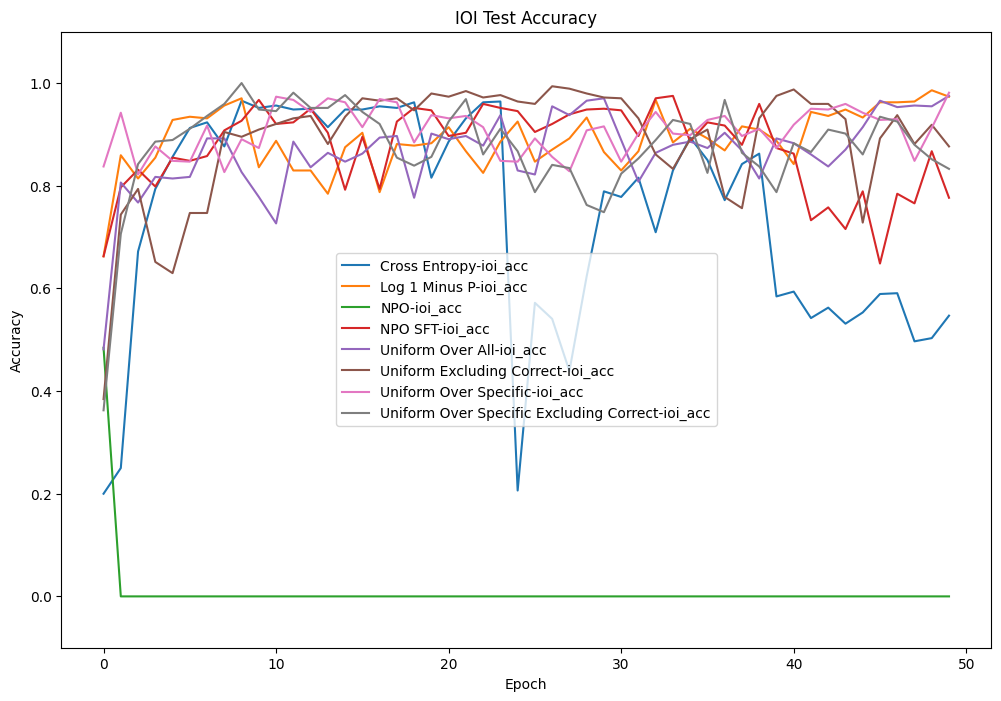

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for loss_name in all_test_losses:
    # loss_types = ['ioi', 'induction', 'owt', 'greaterthan']
    loss_types = ['ioi_acc']
    for loss_type in loss_types:
        losses = []
        for x in all_test_losses[loss_name]:
            try:
                losses.append(x[loss_type].item())
            except:
                losses.append(x[loss_type])
        plt.plot(losses, label=f"{loss_name}-{loss_type}")
plt.legend()

plt.title("IOI Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
# only plot y range from 0 to 3
plt.ylim(-.1, 1.1)

plt.show()

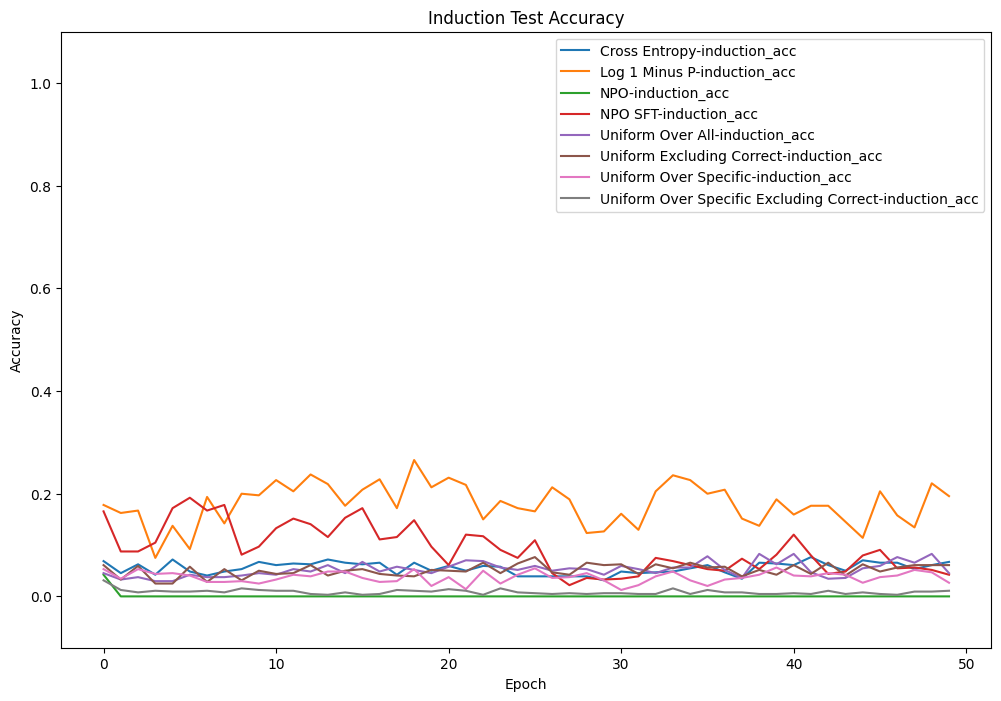

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for loss_name in all_test_losses:
    # loss_types = ['ioi', 'induction', 'owt', 'greaterthan']
    loss_types = ['induction_acc']
    for loss_type in loss_types:
        losses = []
        for x in all_test_losses[loss_name]:
            try:
                losses.append(x[loss_type].item())
            except:
                losses.append(x[loss_type])
        plt.plot(losses, label=f"{loss_name}-{loss_type}")
plt.legend()

plt.title("Induction Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
# only plot y range from 0 to 3
plt.ylim(-.1, 1.1)

plt.show()

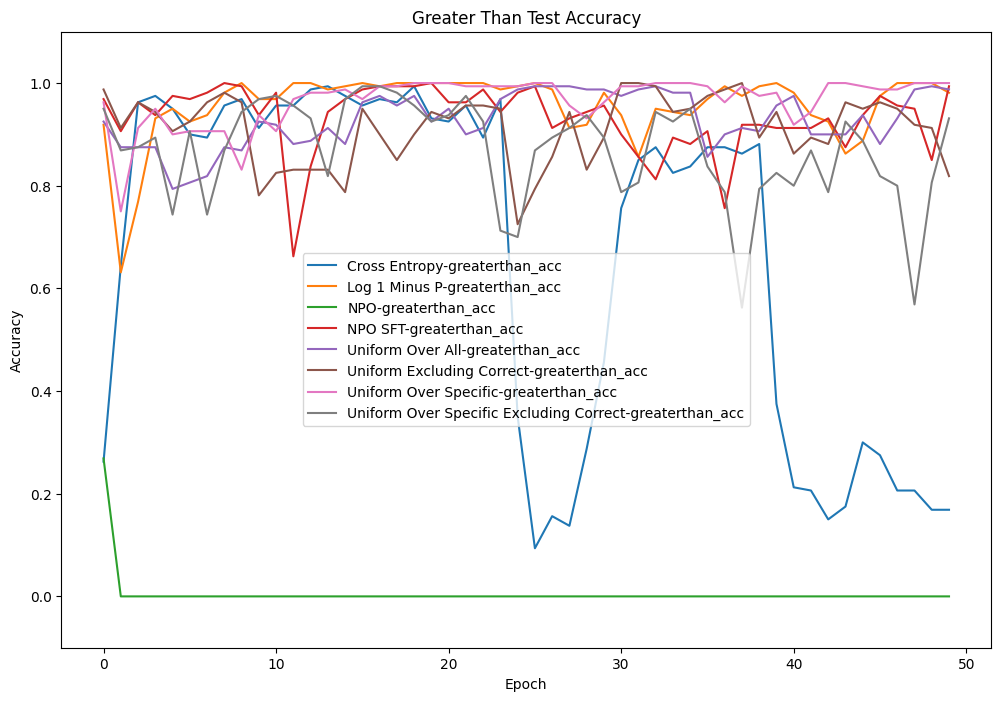

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for loss_name in all_test_losses:
    # loss_types = ['ioi', 'induction', 'owt', 'greaterthan']
    loss_types = ['greaterthan_acc']
    for loss_type in loss_types:
        losses = []
        for x in all_test_losses[loss_name]:
            try:
                losses.append(x[loss_type].item())
            except:
                losses.append(x[loss_type])
        plt.plot(losses, label=f"{loss_name}-{loss_type}")
plt.legend()

plt.title("Greater Than Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
# only plot y range from 0 to 3
plt.ylim(-.1, 1.1)

plt.show()

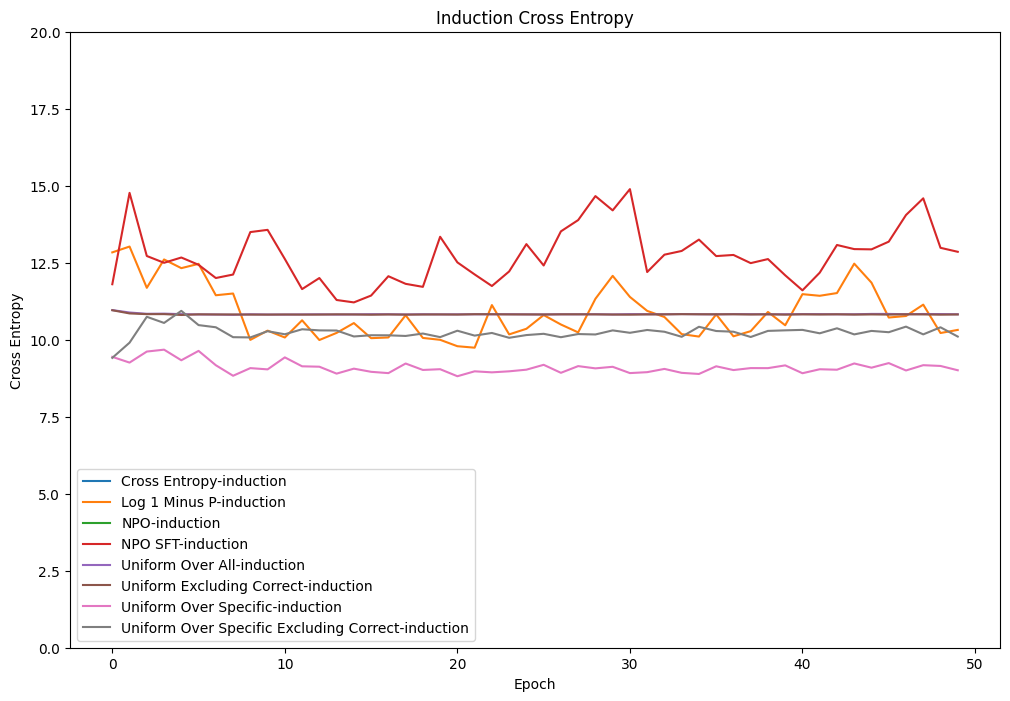

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for loss_name in all_test_losses:
    # loss_types = ['ioi', 'induction', 'owt', 'greaterthan']
    loss_types = ['induction']
    for loss_type in loss_types:
        losses = []
        for x in all_test_losses[loss_name]:
            try:
                losses.append(x[loss_type].item())
            except:
                losses.append(x[loss_type])
        plt.plot(losses, label=f"{loss_name}-{loss_type}")
plt.legend()

plt.title("Induction Cross Entropy")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy")
# only plot y range from 0 to 3
plt.ylim(0, 20)

plt.show()

In [ ]:
all_test_losses